In [1]:
import os, sys, torch, json, time, string, re, pickle, unicodedata, numpy as np, unicodedata
import torch.optim as optim, torch, torch.nn as nn, torch.nn.functional as F
import torch, torch.nn as nn, torch.nn.functional as func, evaluate as ev, time
from tqdm import tqdm
from torch import matmul
from torch.nn.functional import dropout
from torch import LongTensor
from torch.utils.data import Dataset
from torch.autograd import Variable

random_seed = 11
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [2]:
#Load processed datasets with topics

train = []
dev = []

f = open("data/datasets_topics_new/train-v1.1-processed.txt", 'r')
for line in tqdm(f):
    example = json.loads(line)
    if len(example['ans']) > 0:
        train.append(example)
f.close()

f1 = open("data/datasets_topics_new/dev-v1.1-processed.txt", 'r')
for line in tqdm(f1):
    example = json.loads(line)
    if len(example['ans']) > 0:
        dev.append(example)
f1.close()

time.sleep(1)
print('Num train examples = %d' % len(train))
print('Num dev examples = %d' % len(dev))

87599it [00:23, 3772.49it/s]
10570it [00:04, 2588.14it/s]


Num train examples = 86422
Num dev examples = 10493


In [3]:
time.sleep(1)
dev_offsets = {ex['id']: ex['ans_pos'] for ex in dev}
print(time.ctime() + " Build word o index mapping")
time.sleep(1)

all_samples = train + dev
word2idx = {'<NULL>':0, '<UNK>':1} 
char2idx = {'<NULL>':0, '<UNK>':1}

word_set = set()
char_set = set()
feature_set = set()
for each_example in tqdm(all_samples):
    
    for word in each_example['question']:
        word_set.add(word)

    for word in each_example['ctxt']:
        word_set.add(word)

    for char in each_example['ques_char']:
        char_set.add(char)

    for char in each_example['ctxt_char']:
        char_set.add(char)

        
print(time.ctime() + " word_set")

for i, word in enumerate(word_set):
    if word not in word2idx.keys():
        word2idx[word] = i+2


for i, char in enumerate(char_set):
    if char not in char2idx.keys():
        char2idx[char] = i+2

print('#words', len(word2idx))    
print('#chars', len(char2idx))

Mon May  7 19:03:57 2018 Build word o index mapping


100%|██████████| 96915/96915 [00:04<00:00, 20722.09it/s]


Mon May  7 19:04:03 2018 word_set
#words 125516
#chars 757


In [4]:
def load_embeddings(word2idx,char2idx,glove_file):
    
    corpus_words = set()
    for key in word2idx.keys():
        if key not in {'<NULL>','<UNK>'}:
            corpus_words.add(key)
    
    corpus_chars = set()
    for key in char2idx.keys():
        if key not in {'<NULL>','<UNK>'}:
            corpus_chars.add(key)
            
    idx2word = {v: k for k, v in char2idx.items()}
    idx2char = {v: k for k, v in char2idx.items()}
    
    glove_big = {}
    with open(glove_file, "rb") as infile:
        for line in infile:
            parts = line.split()
            word = parts[0].decode()#.lower()
            nums = map(float, parts[1:])
            if (word in corpus_words) or (word in corpus_chars):
                glove_big[word] = list(nums)
                
    idx2word = {v: k for k, v in word2idx.items()}
    
    weights_matrix = np.random.normal(scale=0.6, size=(len(idx2word), 300))#np.zeros((len(idx2word), 300))
    words_found = 0

    for word in corpus_words:
        if word in glove_big.keys():
            weights_matrix[word2idx[word]] = glove_big[word]
            words_found += 1
    print("%d words found out of %d" %(words_found, len(idx2word)))

    weights_matrix_char = np.random.normal(scale=0.6, size=(len(idx2char), 300))#np.zeros((len(idx2word), 300))
    chars_found = 0

    for char in corpus_chars:
        if char in glove_big.keys():
            weights_matrix[char2idx[char]] = glove_big[char]
            chars_found += 1
    print("%d chars found out of %d" %(chars_found, len(idx2char)))
    
    return weights_matrix, weights_matrix_char

In [5]:
weights_matrix, weights_matrix_char = load_embeddings(word2idx,char2idx,'data/glove.840B.300d.txt')

emb_layer = nn.Embedding(num_embeddings= len(word2idx), embedding_dim = 300, padding_idx=0).cuda()
emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))

emb_layer_char = nn.Embedding(num_embeddings= len(char2idx), embedding_dim = 300, padding_idx=0).cuda()
emb_layer_char.weight.data.copy_(torch.from_numpy(weights_matrix_char))

emb_layer.weight.requires_grad = False
emb_layer_char.weight.requires_grad = False

100005 words found out of 125516
263 chars found out of 757


In [6]:
'''
Creating features
'''
class Transform(Dataset):
    def __init__(self, example, word2idx, char2idx,status):#feature2idx
        self.example = example
        self.status = status
        self.word2idx =  word2idx
        self.char2idx =  char2idx
        
        self.feature2idx = {'RB': 4,'DT': 5,'NN': 6,'VBZ': 7,'JJ': 8,'LS': 9,'VB': 10,'NNP': 11,'POS': 12,'IN': 13,'CC': 14,'VBG': 15,'PRP': 16,'NNS': 17,'VBN': 18,'TO': 19,'WRB': 20,
        'VBD': 21,'CD': 22,'PDT': 23,'WDT': 24,'WP': 25,'VBP': 26,'UH': 27,'ORG': 28,'FACILITY': 29,'GPE': 30,'PERSON': 31,'JJS': 32,'NNPS': 33,
        'RP': 34,'LOCATION': 35,'FW': 36,'JJR': 37,'RBS': 38,'MD': 39,'SYM': 40,'EX': 41,'RBR': 42,'GSP': 43}
        
    def __len__(self):
        return len(self.example)

    def __getitem__(self, index):
        
        ctxt = self.example[index]['ctxt']
        ques = self.example[index]['question']
        ctxt_char = self.example[index]['ctxt_char']
        question_char = self.example[index]['ques_char']
        total_length_context = len(ctxt)
        total_length_question = len(ques)
        
        cpos_d = self.example[index]['ctxt_pos']
        cner_d = self.example[index]['ctxt_ner']
        qpos_d = self.example[index]['ques_pos']
        qner_d = self.example[index]['qner']
        
        context_cased = set(ctxt) #all words in context
        context_uncased = set([word.lower() for word in ctxt]) #all words in context lowercase
        word_ques = [self.word2idx.get(word, 1) for word in ques] # get index of question word
        word_con = [self.word2idx.get(word, 1) for word in ctxt] # get index of context word
        ques_cased = set(ques)
        ques_uncased = set([element.lower() for element in ques])
        char_ques = [self.char2idx.get(char, 1) for char in question_char]
        char_con = [self.char2idx.get(char, 1) for char in ctxt_char]
        context_lemmas = set(self.example[index]['ctxt_lemma'])
        ques_lemmas = set(self.example[index]['qlemma'])
        count_of_word_context = {word.lower(): ctxt.count(word.lower()) for word in ctxt}
        count_of_word_question = {word.lower(): ques.count(word.lower()) for word in ques}
        
        #creating question and context feature vector
        context_feature = torch.zeros(len(ctxt), 44)
        ques_feature = torch.zeros(len(ques), 44)
        
        #exact match features being one 
        for i in range(len(ctxt)):
            if ctxt[i] in ques_cased:
                context_feature[i][0] = 1.0
            if ctxt[i] in ques_uncased:
                context_feature[i][1] = 1.0
            if ctxt[i] in ques_lemmas:
                context_feature[i][2] = 1.0
            
        for i in range(len(cpos_d)):
            f = cpos_d[i]
            if f in self.feature2idx:
                context_feature[i][self.feature2idx[f]] = 1.0
            
        for i in range(len(cner_d)):
            f = cner_d[i]
            if f in self.feature2idx:
                context_feature[i][self.feature2idx[f]] = 1.0
        
        for i in range(len(qpos_d)):
            f = qpos_d[i]
            if f in self.feature2idx:
                ques_feature[i][self.feature2idx[f]] = 1.0
            
        for i in range(len(qner_d)):
            f = qner_d[i]
            if f in self.feature2idx:
                ques_feature[i][self.feature2idx[f]] = 1.0

        for i in range(len(ques)):
            if ques[i] in ques_cased:
                ques_feature[i][0] = 1.0
            if ques[i] in ques_uncased:
                ques_feature[i][1] = 1.0
            if ques[i] in ques_lemmas:
                ques_feature[i][2] = 1.0
            
        for i in range(total_length_context):
            context_feature[i][3] = float(count_of_word_context[ctxt[i].lower()]/(1.0 * total_length_context))
        
        for i in range(total_length_question):
            ques_feature[i][3] = float(count_of_word_question[ques[i].lower()]/ (1.0 * total_length_question))

        if self.status == 'train': # take only the first answer
            start_positions = LongTensor(1).fill_(self.example[index]['ans'][0][0])
            end_positions = LongTensor(1).fill_(self.example[index]['ans'][0][1])
        else: # consider all answers while evaluating
            start_positions = []
            end_positions = []
            for ans in self.example[index]['ans']:
                start_positions.append(ans[0])
                end_positions.append(ans[1])
                
        return LongTensor(word_con), LongTensor(char_con), context_feature, LongTensor(word_ques), LongTensor(char_ques), ques_feature, start_positions, end_positions, self.example[index]['id']

In [7]:
train_dataset = Transform(train, word2idx, char2idx, status='train') #feature2idx,
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
dev_dataset = Transform(dev, word2idx, char2idx, status='test') #feature2idx,
dev_sampler = torch.utils.data.sampler.SequentialSampler(dev_dataset)
print(len(dev_dataset))

10493


In [8]:
'''
padding batches to same length
'''
def module_fn(batch_len, con_features, con_words, con_char,max_len): #
    con1_words = LongTensor(batch_len,max_len).zero_() #N X max_len
    con1_chars = LongTensor(batch_len,max_len).zero_()
    con1_features = torch.zeros(batch_len,max_len,con_features[0].size(1))

    for i in range(batch_len):
        con1_words[i,0:con_words[i].size(0)].copy_(con_words[i])
        con1_chars[i, 0:con_char[i].size(0)].copy_(con_char[i])
        con1_features[i,:con_words[i].size(0)].copy_(con_features[i])

    return con1_words, con1_chars, con1_features, #con1_masked_val

def pad_batch(batch):
    
    con_words = []
    con_char = []
    con_features = []
    ques_words = []
    ques_char = []
    ques_features = []
    ids = []

    length_con = []
    length_ques = []
    for val in batch:
        con_words.append(val[0])
        length_con.append(val[0].size(0))
        con_char.append(val[1])
        con_features.append(val[2])
        ques_words.append(val[3])
        length_ques.append(val[3].size(0))
        ques_char.append(val[4])
        ques_features.append(val[5])
        ids.append(val[len(val)-1])

    if torch.is_tensor(batch[0][6]): #train
        abc1 = []
        abc2 = []
        for val in batch:
            abc1.append(val[6])
            abc2.append(val[7])
        batch_start_positions = torch.cat(abc1)
        batch_end_positions = torch.cat(abc2)
    else:        #eval mode
        batch_start_positions = []
        batch_end_positions = []
        for val in batch:
            batch_start_positions.append(val[6])
            batch_end_positions.append(val[7])
    return (*module_fn(len(batch), con_features, con_words, con_char,max(length_con))),length_con,(*module_fn(len(batch), ques_features, ques_words, ques_char,max(length_ques))), length_ques, batch_start_positions, batch_end_positions, ids


In [9]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=45, sampler=train_sampler, num_workers=5, collate_fn=pad_batch, pin_memory=True,)

dev_loader = torch.utils.data.DataLoader(
        dev_dataset, batch_size=32, sampler=dev_sampler, num_workers=5, collate_fn=pad_batch, pin_memory=True,)

In [10]:
def Attention(attn, con, ques): 
    
    if attn == 'interac': 
        coattn = matmul(con, ques.transpose(2,1))    
    else: 
        coattn = matmul(ques, ques.transpose(2,1))
        #set diagonal elements to 0
        for i in range(coattn.size(0)):
            mask = torch.diag(torch.ones(min(coattn.size(1),coattn.size(2)))).cuda()
            coattn[i, :, :].data = mask*0 + (1. - mask)*coattn[i, :, :].data
            
    attn_dist = func.softmax(coattn, dim=2) #attention distribution of query for jth context word
    attended = matmul(attn_dist, ques) #attended query vector for all context words
    return attended

def encode(rnn, seq, lengths, flag):
    
    key=sorted(range(len(lengths)), key=lambda k: lengths[k], reverse=True)

    seq = seq.index_select(0, Variable(torch.LongTensor(key).cuda())).transpose(0, 1)
    rnn_input = nn.utils.rnn.pack_padded_sequence(seq, sorted(lengths, reverse=True))
    rev_key = sorted(range(len(key)), key=lambda k: key[k])
    dropout_input = func.dropout(rnn_input.data, p=0.2, training=flag)
    rnn_input = nn.utils.rnn.PackedSequence(dropout_input, rnn_input.batch_sizes)
    output = rnn(rnn_input)[0]
    output = nn.utils.rnn.pad_packed_sequence(output)[0].transpose(0, 1).index_select(0, Variable(torch.LongTensor(rev_key).cuda()))
    output = func.dropout(output,p=0.2,training=flag)
    
    return output.contiguous() 

In [11]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.char_rnn = nn.LSTM(input_size=300, hidden_size=50, bidirectional=True)
        doc_input_size = 400 + 44
        self.encoding_rnn = nn.LSTM(input_size=doc_input_size, hidden_size=100, bidirectional=True)
        self.sfu_l1 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        self.sfu_l2 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        self.sfu_self_l1 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        self.sfu_self_l2 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        
        self.final_rec_nn = nn.ModuleList([nn.LSTM(input_size=200, hidden_size=100, bidirectional=True),nn.LSTM(input_size=200, hidden_size=100, bidirectional=True)])
        #
        FCN = nn.Sequential(
                nn.Linear(600, 100),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(100, 1),)
        
        self.FeedForward_s = nn.ModuleList([FCN,FCN])
        self.sfu_s_l1 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        self.sfu_s_l2 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        self.FeedForward_e = nn.ModuleList([FCN,FCN])
        self.sfu_e_l1 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        self.sfu_e_l2 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        
        
    def forward(self, con_embed_words, con_embed_chars, con_feat, con_length, ques_embed_words, ques_embed_chars, ques_feat, ques_length):
       
        con_char_feat = encode(self.char_rnn, con_embed_chars, con_length, self.training) #encode context characters
        ques_char_feat = encode(self.char_rnn, ques_embed_chars, ques_length, self.training)#encode question characters
        val1 = torch.cat([con_embed_words,con_char_feat,con_feat], 2)#join all context features
        encoded_con = encode(self.encoding_rnn, val1, con_length, self.training)#encode context
        val2 = torch.cat([ques_embed_words,ques_char_feat,ques_feat], 2)#join all question features
        encoded_ques = encode(self.encoding_rnn, val2, ques_length, self.training)#encode question
        ctxt = encoded_con
        
        for i in range(2):
            #interactive aligning
            attended_ques = Attention('interac', ctxt, encoded_ques)
            #compute query aware representation
            val_s = torch.cat([ctxt, attended_ques, torch.mul(ctxt, attended_ques), ctxt - attended_ques], 2)
            comp = func.tanh(self.sfu_l1[i](val_s))
            gate = func.sigmoid(self.sfu_l2[i](val_s))
            ques_aware_ctxt = gate * comp + (1-gate) * ctxt #queey aware ctxt
            #self aligning
            attended_ctxt = Attention('self',0,ques_aware_ctxt)
            #compute context aware representation
            val_s = torch.cat([ques_aware_ctxt, attended_ctxt, torch.mul(ques_aware_ctxt,attended_ctxt), ques_aware_ctxt - attended_ctxt], 2)
            comp = func.tanh(self.sfu_self_l1[i](val_s))
            gate = func.sigmoid(self.sfu_self_l2[i](val_s))
            ctxt_aware_ctxt = gate * comp + (1-gate) * attended_ctxt # self-aware
            #Aggregating
            ctxt = encode(self.final_rec_nn[i], ctxt_aware_ctxt, con_length, self.training)
        
        #memory Answer Pointer
        memory_s = encoded_ques[:,-1,:].resize(encoded_ques.size(0),1, encoded_ques.size(2))
         
        for i in range(2):
            #prob dist for start using memory and fully aware context
            start = self.FeedForward_s[i](torch.cat([ctxt, memory_s.expand(-1,ctxt.size(1),-1), torch.mul(ctxt,memory_s.expand(-1,ctxt.size(1),-1))], 2))
            start_prob = func.softmax(start.squeeze(2), dim=1) 
            #evidence vector for start
            evidence_s = matmul(start_prob.unsqueeze(1),ctxt)
            
            #fuse memory and evidence
            val_s = torch.cat([memory_s, evidence_s], 2)
            l1_s = func.tanh(self.sfu_s_l1[i](val_s))
            gate = func.sigmoid(self.sfu_s_l2[i](val_s))
            memory_e = gate * l1_s + (1-gate) * memory_s #new memory
            
            #prob dist for end using new memory and fully aware context
            end = self.FeedForward_e[i](torch.cat([ctxt, memory_e.expand(-1,ctxt.size(1),-1), torch.mul(ctxt,memory_e.expand(-1,ctxt.size(1),-1))], 2))
            end_prob = func.softmax(end.squeeze(2), dim=1)
            #evidence vector for end
            evidence_e = matmul(end_prob.resize(end_prob.size(0),1, end_prob.size(1)),ctxt)
            
            # fuse to generate new memory
            val_e = torch.cat([memory_e, evidence_e], 2)
            l1_e = func.tanh(self.sfu_e_l1[i](val_e))
            gate_e = func.sigmoid(self.sfu_e_l2[i](val_e))
            memory_s = gate_e * l1_e + (1-gate_e) * memory_e

        start_prob = func.log_softmax(start.squeeze(2), dim=1) 
        end_prob = func.log_softmax(end.squeeze(2), dim=1)
        
        #print(end_prob.size())
        #print(start_prob.size())
    
        return start_prob, end_prob

In [ ]:
# Initialize the model
reader = Model().cuda()
optimizer = optim.Adamax(reader.parameters())
torch.cuda.set_device(-1)
model_name = 'with_topics_best'

In [12]:
# find mle
def findmax(score_s,score_e):
    max_len = 15
    pred_s = []
    pred_e = []
    dim = score_s.shape[1]
    
    for i in range(score_s.shape[0]):
        joint = np.zeros((dim,dim))
        for start in range(dim):
            if start+max_len < dim:
                joint[start,start:start+max_len]=score_s[i,:][start]*score_e[i,:][start:start+max_len]
            else:
                joint[start,start:dim] = score_s[i,:][start]*score_e[i,:][start:dim]
                
        s_idx, e_idx = np.argwhere(joint.max() == joint)[0,:] 
        
        pred_s.append(s_idx)
        pred_e.append(e_idx)
        
    return pred_s, pred_e

def validate(data_loader, network, positions, texts, answers, official):
    f1 = 0
    em = 0
    examples = 0
    results = {}
    for ex in data_loader:
        batch_size = ex[0].size(0)
        ex_id = ex[-1]
        
        #Predicting....
        network.eval()

        con_words = Variable(ex[0].cuda())
        con_chars = Variable(ex[1].cuda())
        con_feat = Variable(ex[2].cuda())
        ques_words = Variable(ex[4].cuda())
        ques_chars = Variable(ex[5].cuda())
        ques_feat = Variable(ex[6].cuda())

        con_embed_words = func.dropout(emb_layer(con_words), p=0.2)
        ques_embed_words = func.dropout(emb_layer(ques_words), p=0.2)
        con_embed_chars = func.dropout(emb_layer_char(con_chars), p=0.2)
        ques_embed_chars = func.dropout(emb_layer_char(ques_chars), p=0.2)

        score_s, score_e = network(con_embed_words,con_embed_chars,con_feat,ex[3],ques_embed_words,ques_embed_chars,ques_feat,ex[7])
        score_s.exp_() 
        score_e.exp_()
        pred_s, pred_e = findmax(score_s.data.cpu().numpy(),score_e.data.cpu().numpy())

        for i in range(batch_size):
            
            s_posn = positions[ex_id[i]][pred_s[i]][0]
            e_posn = positions[ex_id[i]][pred_e[i]][1]
            prediction = texts[ex_id[i]][s_posn:e_posn]
            
            if official:
                results[ex_id[i]]=prediction

            ground_truths = answers[ex_id[i]]
            em += ev.metric_max_over_ground_truths(ev.exact_match_score, prediction, ground_truths)
            f1 += ev.metric_max_over_ground_truths(ev.f1_score, prediction, ground_truths)
                 
        examples += batch_size
    
    if official:
        return f1/examples, em/examples, results
    else:
        return f1/examples, em/examples

In [14]:
dev_texts = {}
dev_answers = {}
f2 = open("data/datasets_topics_new/dev-v1.1.json", 'r')
examples = json.load(f2)['data']
for article in tqdm(examples):
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            dev_texts[qa['id']] = paragraph['context']
            dev_answers[qa['id']] = list(map(lambda x: x['text'], qa['answers']))
f2.close()

100%|██████████| 48/48 [00:00<00:00, 2498.38it/s]


In [15]:
#training
batch_size = 45
num_epochs = 14 
best_f1 = 0

loss_list = []
f1_list = []
em_list = []
epoch_list = []

for epoch in tqdm(range(0, num_epochs)):
    loss_list.append([])
    train_loss = 0
    for idx, sample in enumerate(train_loader): 

        reader.train()

        con_words = Variable(sample[0].cuda())
        con_chars = Variable(sample[1].cuda())
        con_feat = Variable(sample[2].cuda())
        ques_words = Variable(sample[4].cuda())
        ques_chars = Variable(sample[5].cuda())
        ques_feat = Variable(sample[6].cuda())
        target_start = Variable(sample[8].cuda())
        target_end = Variable(sample[9].cuda())
        
        con_embed_words = func.dropout(emb_layer(con_words), p=0.2)
        ques_embed_words = func.dropout(emb_layer(ques_words), p=0.2)
        con_embed_chars = func.dropout(emb_layer_char(con_chars), p=0.2)
        ques_embed_chars = func.dropout(emb_layer_char(ques_chars), p=0.2)
        
        pred_start, pred_end = reader(con_embed_words,con_embed_chars,con_feat,sample[3],ques_embed_words,ques_embed_chars,ques_feat,sample[7])
        
        loss = func.nll_loss(pred_start, target_start) + func.nll_loss(pred_end, target_end)#calculate loss
        optimizer.zero_grad() #set gradients to zero for each iteration
        loss.backward() #backpropagate
        torch.nn.utils.clip_grad_norm(reader.parameters(), max_norm=10)#clip gradients to avoid exploding gradients
        optimizer.step() #update parameters

        train_loss += loss.data[0]
        if(idx % 50 == 0):
            loss_epoch_internal = train_loss/batch_size
            loss_list[epoch].append(loss_epoch_internal)
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/", len(train_loader), "\tloss", loss_epoch_internal)
            train_loss=0
#             if(idx == 50):
#                 break
            if(idx % 200 == 0):
                with open('graph_elem.pkl', 'wb') as f:
                    pickle.dump([loss_list, f1_list, em_list, epoch_list], f)

    time_id = str(int(time.time()))
    f1, em, results = validate(dev_loader, reader, dev_offsets, dev_texts, dev_answers, official=True)
    print("Epoch:", epoch + 1, "Dev F1:", f1, "EM:", em, "\n")
    f1_list.append(f1)
    em_list.append(em)
    epoch_list.append(epoch)
    
    if f1 > best_f1:
        model_name_cur = model_name+"_"+time_id+"_epoch_"+str(epoch+1)+"_F1_"+str(round(f1*100,2)).replace('.','_')+".mdl"
        torch.save(reader.state_dict(), "data/models/"+model_name_cur+'.pt')
        best_f1 = f1

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Batch-step 0 	/ 1921 	loss 0.2547504213121202
Epoch 1 Batch-step 50 	/ 1921 	loss 11.05772533416748
Epoch 1 Batch-step 100 	/ 1921 	loss 10.836053699917263
Epoch 1 Batch-step 150 	/ 1921 	loss 10.766353437635633
Epoch 1 Batch-step 200 	/ 1921 	loss 10.741842036777072
Epoch 1 Batch-step 250 	/ 1921 	loss 10.440506299336752
Epoch 1 Batch-step 300 	/ 1921 	loss 9.555918439229329
Epoch 1 Batch-step 350 	/ 1921 	loss 9.187462732526992
Epoch 1 Batch-step 400 	/ 1921 	loss 8.761592303382026
Epoch 1 Batch-step 450 	/ 1921 	loss 8.352630509270561
Epoch 1 Batch-step 500 	/ 1921 	loss 7.9335609118143715
Epoch 1 Batch-step 550 	/ 1921 	loss 7.776992162068685
Epoch 1 Batch-step 600 	/ 1921 	loss 7.499982293446859
Epoch 1 Batch-step 650 	/ 1921 	loss 7.272015232510037
Epoch 1 Batch-step 700 	/ 1921 	loss 7.11052762137519
Epoch 1 Batch-step 750 	/ 1921 	loss 7.051740349663628
Epoch 1 Batch-step 800 	/ 1921 	loss 7.037395519680447
Epoch 1 Batch-step 850 	/ 1921 	loss 6.951922713385688
Epoch 1 

  7%|▋         | 1/14 [20:27<4:26:02, 1227.88s/it]

Epoch: 1 Dev F1: 0.5529584567066161 EM: 0.4353378442771371 

Epoch 2 Batch-step 0 	/ 1921 	loss 0.11871244642469618
Epoch 2 Batch-step 50 	/ 1921 	loss 5.272496361202664
Epoch 2 Batch-step 100 	/ 1921 	loss 5.3293135748969185
Epoch 2 Batch-step 150 	/ 1921 	loss 5.432217968834771
Epoch 2 Batch-step 200 	/ 1921 	loss 5.269993766148885
Epoch 2 Batch-step 250 	/ 1921 	loss 5.323973359002007
Epoch 2 Batch-step 300 	/ 1921 	loss 5.27479461034139
Epoch 2 Batch-step 350 	/ 1921 	loss 5.139448923534817
Epoch 2 Batch-step 400 	/ 1921 	loss 5.290340810351902
Epoch 2 Batch-step 450 	/ 1921 	loss 5.089646848042806
Epoch 2 Batch-step 500 	/ 1921 	loss 5.148573674096001
Epoch 2 Batch-step 550 	/ 1921 	loss 5.06991785897149
Epoch 2 Batch-step 600 	/ 1921 	loss 4.962438011169434
Epoch 2 Batch-step 650 	/ 1921 	loss 5.17413428624471
Epoch 2 Batch-step 700 	/ 1921 	loss 4.866912937164306
Epoch 2 Batch-step 750 	/ 1921 	loss 5.028095287746853
Epoch 2 Batch-step 800 	/ 1921 	loss 4.832735045750936
Epoch 2

 14%|█▍        | 2/14 [40:58<4:05:49, 1229.14s/it]

Epoch: 2 Dev F1: 0.6392619177165166 EM: 0.5277804250452682 

Epoch 3 Batch-step 0 	/ 1921 	loss 0.10859688652886285
Epoch 3 Batch-step 50 	/ 1921 	loss 4.53066594335768
Epoch 3 Batch-step 100 	/ 1921 	loss 4.46955935160319
Epoch 3 Batch-step 150 	/ 1921 	loss 4.290693034066094
Epoch 3 Batch-step 200 	/ 1921 	loss 4.266759220759074
Epoch 3 Batch-step 250 	/ 1921 	loss 4.2634041044447155
Epoch 3 Batch-step 300 	/ 1921 	loss 4.30872418085734
Epoch 3 Batch-step 350 	/ 1921 	loss 4.30916232003106
Epoch 3 Batch-step 400 	/ 1921 	loss 4.395767174826728
Epoch 3 Batch-step 450 	/ 1921 	loss 4.3163291719224715
Epoch 3 Batch-step 500 	/ 1921 	loss 4.431751033994886
Epoch 3 Batch-step 550 	/ 1921 	loss 4.43188067012363
Epoch 3 Batch-step 600 	/ 1921 	loss 4.285953844918145
Epoch 3 Batch-step 650 	/ 1921 	loss 4.309066147274441
Epoch 3 Batch-step 700 	/ 1921 	loss 4.274071386125352
Epoch 3 Batch-step 750 	/ 1921 	loss 4.408430512746175
Epoch 3 Batch-step 800 	/ 1921 	loss 4.261750671598646
Epoch 3 

 21%|██▏       | 3/14 [1:01:30<3:45:31, 1230.14s/it]

Epoch: 3 Dev F1: 0.6930568973345579 EM: 0.5811493376536738 

Epoch 4 Batch-step 0 	/ 1921 	loss 0.07078394360012479
Epoch 4 Batch-step 50 	/ 1921 	loss 3.998022821214464
Epoch 4 Batch-step 100 	/ 1921 	loss 3.7304390059577095
Epoch 4 Batch-step 150 	/ 1921 	loss 3.7769895023769804
Epoch 4 Batch-step 200 	/ 1921 	loss 3.794175211588542
Epoch 4 Batch-step 250 	/ 1921 	loss 3.9088405821058485
Epoch 4 Batch-step 300 	/ 1921 	loss 3.855577802658081
Epoch 4 Batch-step 350 	/ 1921 	loss 3.8561819553375245
Epoch 4 Batch-step 400 	/ 1921 	loss 3.7040399180518255
Epoch 4 Batch-step 450 	/ 1921 	loss 3.8292695787217883
Epoch 4 Batch-step 500 	/ 1921 	loss 3.7311985280778672
Epoch 4 Batch-step 550 	/ 1921 	loss 3.794071658452352
Epoch 4 Batch-step 600 	/ 1921 	loss 3.775224701563517
Epoch 4 Batch-step 650 	/ 1921 	loss 3.7721218321058485
Epoch 4 Batch-step 700 	/ 1921 	loss 3.92039459016588
Epoch 4 Batch-step 750 	/ 1921 	loss 3.7338969495561387
Epoch 4 Batch-step 800 	/ 1921 	loss 3.6337882889641

 29%|██▊       | 4/14 [1:22:02<3:25:05, 1230.57s/it]

Epoch: 4 Dev F1: 0.7176756516865082 EM: 0.611931764033165 

Epoch 5 Batch-step 0 	/ 1921 	loss 0.07035887506273057
Epoch 5 Batch-step 50 	/ 1921 	loss 3.3469825108846027
Epoch 5 Batch-step 100 	/ 1921 	loss 3.4456782976786298
Epoch 5 Batch-step 150 	/ 1921 	loss 3.5198371516333684
Epoch 5 Batch-step 200 	/ 1921 	loss 3.5734121799468994
Epoch 5 Batch-step 250 	/ 1921 	loss 3.4597330464257134
Epoch 5 Batch-step 300 	/ 1921 	loss 3.5595535861121284
Epoch 5 Batch-step 350 	/ 1921 	loss 3.600385565227932
Epoch 5 Batch-step 400 	/ 1921 	loss 3.4370111677381727
Epoch 5 Batch-step 450 	/ 1921 	loss 3.5875237464904783
Epoch 5 Batch-step 500 	/ 1921 	loss 3.423928123050266
Epoch 5 Batch-step 550 	/ 1921 	loss 3.4401857588026257
Epoch 5 Batch-step 600 	/ 1921 	loss 3.3109937296973335
Epoch 5 Batch-step 650 	/ 1921 	loss 3.4586577733357746
Epoch 5 Batch-step 700 	/ 1921 	loss 3.476505735185411
Epoch 5 Batch-step 750 	/ 1921 	loss 3.4421739101409914
Epoch 5 Batch-step 800 	/ 1921 	loss 3.5363928106

 36%|███▌      | 5/14 [1:42:30<3:04:30, 1230.10s/it]

Epoch: 5 Dev F1: 0.7422138626172001 EM: 0.6417611741160774 

Epoch 6 Batch-step 0 	/ 1921 	loss 0.0765817748175727
Epoch 6 Batch-step 50 	/ 1921 	loss 3.2764962832132976
Epoch 6 Batch-step 100 	/ 1921 	loss 3.1655679490831163
Epoch 6 Batch-step 150 	/ 1921 	loss 3.1126551893022327
Epoch 6 Batch-step 200 	/ 1921 	loss 3.221733988655938
Epoch 6 Batch-step 250 	/ 1921 	loss 3.263576300938924
Epoch 6 Batch-step 300 	/ 1921 	loss 3.1977649052937824
Epoch 6 Batch-step 350 	/ 1921 	loss 3.266881407631768
Epoch 6 Batch-step 400 	/ 1921 	loss 3.259074526362949
Epoch 6 Batch-step 450 	/ 1921 	loss 3.2506847434573705
Epoch 6 Batch-step 500 	/ 1921 	loss 3.17359540992313
Epoch 6 Batch-step 550 	/ 1921 	loss 3.0828008307351005
Epoch 6 Batch-step 600 	/ 1921 	loss 3.2552939785851374
Epoch 6 Batch-step 650 	/ 1921 	loss 3.1857826656765407
Epoch 6 Batch-step 700 	/ 1921 	loss 3.2986079639858668
Epoch 6 Batch-step 750 	/ 1921 	loss 3.194117122226291
Epoch 6 Batch-step 800 	/ 1921 	loss 3.32389501465691

 43%|████▎     | 6/14 [2:03:00<2:44:00, 1230.10s/it]

Epoch: 6 Dev F1: 0.7495933956845299 EM: 0.6504336224149433 

Epoch 7 Batch-step 0 	/ 1921 	loss 0.05175872378879123
Epoch 7 Batch-step 50 	/ 1921 	loss 3.238072633743286
Epoch 7 Batch-step 100 	/ 1921 	loss 3.1191572666168215
Epoch 7 Batch-step 150 	/ 1921 	loss 2.9737478256225587
Epoch 7 Batch-step 200 	/ 1921 	loss 3.084012677934435
Epoch 7 Batch-step 250 	/ 1921 	loss 3.026157644059923
Epoch 7 Batch-step 300 	/ 1921 	loss 3.0491312821706136
Epoch 7 Batch-step 350 	/ 1921 	loss 3.0593273745642766
Epoch 7 Batch-step 400 	/ 1921 	loss 2.904367611143324
Epoch 7 Batch-step 450 	/ 1921 	loss 3.0725754525926376
Epoch 7 Batch-step 500 	/ 1921 	loss 2.935639667510986
Epoch 7 Batch-step 550 	/ 1921 	loss 2.9958475059933134
Epoch 7 Batch-step 600 	/ 1921 	loss 3.0572371986177234
Epoch 7 Batch-step 650 	/ 1921 	loss 2.9628492487801448
Epoch 7 Batch-step 700 	/ 1921 	loss 3.141590640279982
Epoch 7 Batch-step 750 	/ 1921 	loss 3.1183847109476726
Epoch 7 Batch-step 800 	/ 1921 	loss 3.055253203709

 50%|█████     | 7/14 [2:23:32<2:23:32, 1230.43s/it]

Epoch: 7 Dev F1: 0.7526001927803987 EM: 0.652053750119127 

Epoch 8 Batch-step 0 	/ 1921 	loss 0.059061532550387916
Epoch 8 Batch-step 50 	/ 1921 	loss 2.9383343696594237
Epoch 8 Batch-step 100 	/ 1921 	loss 2.859563700358073
Epoch 8 Batch-step 150 	/ 1921 	loss 2.9136952744589912
Epoch 8 Batch-step 200 	/ 1921 	loss 2.8277170658111572
Epoch 8 Batch-step 250 	/ 1921 	loss 2.906349547704061
Epoch 8 Batch-step 300 	/ 1921 	loss 2.9388420767254297
Epoch 8 Batch-step 350 	/ 1921 	loss 2.891832865609063
Epoch 8 Batch-step 400 	/ 1921 	loss 2.9477302683724296
Epoch 8 Batch-step 450 	/ 1921 	loss 2.9244398434956866
Epoch 8 Batch-step 500 	/ 1921 	loss 2.942857461505466
Epoch 8 Batch-step 550 	/ 1921 	loss 2.8787273195054794
Epoch 8 Batch-step 600 	/ 1921 	loss 2.9213425636291506
Epoch 8 Batch-step 650 	/ 1921 	loss 2.864962159262763
Epoch 8 Batch-step 700 	/ 1921 	loss 2.932773968908522
Epoch 8 Batch-step 750 	/ 1921 	loss 2.938024732801649
Epoch 8 Batch-step 800 	/ 1921 	loss 3.0238775279786

 57%|█████▋    | 8/14 [2:43:59<2:02:59, 1229.90s/it]

Epoch: 8 Dev F1: 0.7625197445282095 EM: 0.6670161059754122 

Epoch 9 Batch-step 0 	/ 1921 	loss 0.04977151023017035
Epoch 9 Batch-step 50 	/ 1921 	loss 2.9188483926985
Epoch 9 Batch-step 100 	/ 1921 	loss 2.772373104095459
Epoch 9 Batch-step 150 	/ 1921 	loss 2.720060772365994
Epoch 9 Batch-step 200 	/ 1921 	loss 2.79817451900906
Epoch 9 Batch-step 250 	/ 1921 	loss 2.8793669197294447
Epoch 9 Batch-step 300 	/ 1921 	loss 2.7321633630328708
Epoch 9 Batch-step 350 	/ 1921 	loss 2.64027325047387
Epoch 9 Batch-step 400 	/ 1921 	loss 2.6926157898373075
Epoch 9 Batch-step 450 	/ 1921 	loss 2.7059286488427055
Epoch 9 Batch-step 500 	/ 1921 	loss 2.7426025523079764
Epoch 9 Batch-step 550 	/ 1921 	loss 2.8465079148610433
Epoch 9 Batch-step 600 	/ 1921 	loss 2.8121174706353083
Epoch 9 Batch-step 650 	/ 1921 	loss 2.793894910812378
Epoch 9 Batch-step 700 	/ 1921 	loss 2.7264138327704535
Epoch 9 Batch-step 750 	/ 1921 	loss 2.7777887238396537
Epoch 9 Batch-step 800 	/ 1921 	loss 2.901790486441718


 64%|██████▍   | 9/14 [3:04:32<1:42:31, 1230.28s/it]

Epoch: 9 Dev F1: 0.7634442400724794 EM: 0.6649194701229391 

Epoch 10 Batch-step 0 	/ 1921 	loss 0.05460311041937934
Epoch 10 Batch-step 50 	/ 1921 	loss 2.5933505323198105
Epoch 10 Batch-step 100 	/ 1921 	loss 2.7622719022962783
Epoch 10 Batch-step 150 	/ 1921 	loss 2.6616420216030545
Epoch 10 Batch-step 200 	/ 1921 	loss 2.610416407055325
Epoch 10 Batch-step 250 	/ 1921 	loss 2.707951625188192
Epoch 10 Batch-step 300 	/ 1921 	loss 2.7325144529342653
Epoch 10 Batch-step 350 	/ 1921 	loss 2.589998330010308
Epoch 10 Batch-step 400 	/ 1921 	loss 2.6111724456151326
Epoch 10 Batch-step 450 	/ 1921 	loss 2.6869969844818113
Epoch 10 Batch-step 500 	/ 1921 	loss 2.710002695189582
Epoch 10 Batch-step 550 	/ 1921 	loss 2.571962266498142
Epoch 10 Batch-step 600 	/ 1921 	loss 2.6759458700815837
Epoch 10 Batch-step 650 	/ 1921 	loss 2.7445180416107178
Epoch 10 Batch-step 700 	/ 1921 	loss 2.7420851283603245
Epoch 10 Batch-step 750 	/ 1921 	loss 2.721871503194173
Epoch 10 Batch-step 800 	/ 1921 	lo

 71%|███████▏  | 10/14 [3:25:02<1:22:00, 1230.23s/it]

Epoch: 10 Dev F1: 0.7689220727408721 EM: 0.6756885542742781 

Epoch 11 Batch-step 0 	/ 1921 	loss 0.050475353664822045
Epoch 11 Batch-step 50 	/ 1921 	loss 2.554087315665351
Epoch 11 Batch-step 100 	/ 1921 	loss 2.5844193776448567
Epoch 11 Batch-step 150 	/ 1921 	loss 2.5328456825680203
Epoch 11 Batch-step 200 	/ 1921 	loss 2.6047031296624077
Epoch 11 Batch-step 250 	/ 1921 	loss 2.6461966064241196
Epoch 11 Batch-step 300 	/ 1921 	loss 2.6882030063205296
Epoch 11 Batch-step 350 	/ 1921 	loss 2.576542851659987
Epoch 11 Batch-step 400 	/ 1921 	loss 2.668660857942369
Epoch 11 Batch-step 450 	/ 1921 	loss 2.623298989401923
Epoch 11 Batch-step 500 	/ 1921 	loss 2.5961091942257353
Epoch 11 Batch-step 550 	/ 1921 	loss 2.662731628947788
Epoch 11 Batch-step 600 	/ 1921 	loss 2.564129442638821
Epoch 11 Batch-step 650 	/ 1921 	loss 2.5919566551844277
Epoch 11 Batch-step 700 	/ 1921 	loss 2.6249983946482343
Epoch 11 Batch-step 750 	/ 1921 	loss 2.586639396349589
Epoch 11 Batch-step 800 	/ 1921 	l

 79%|███████▊  | 11/14 [3:45:29<1:01:29, 1229.98s/it]

Epoch: 11 Dev F1: 0.7699888692038909 EM: 0.6732107119031735 

Epoch 12 Batch-step 0 	/ 1921 	loss 0.046400361590915255
Epoch 12 Batch-step 50 	/ 1921 	loss 2.588837676578098
Epoch 12 Batch-step 100 	/ 1921 	loss 2.5123135381274753
Epoch 12 Batch-step 150 	/ 1921 	loss 2.5514962885114882
Epoch 12 Batch-step 200 	/ 1921 	loss 2.5665765629874335
Epoch 12 Batch-step 250 	/ 1921 	loss 2.451261456807454
Epoch 12 Batch-step 300 	/ 1921 	loss 2.62489693959554
Epoch 12 Batch-step 350 	/ 1921 	loss 2.517939069535997
Epoch 12 Batch-step 400 	/ 1921 	loss 2.461516931321886
Epoch 12 Batch-step 450 	/ 1921 	loss 2.4256924947102863
Epoch 12 Batch-step 500 	/ 1921 	loss 2.5098141696718006
Epoch 12 Batch-step 550 	/ 1921 	loss 2.59414930873447
Epoch 12 Batch-step 600 	/ 1921 	loss 2.548217855559455
Epoch 12 Batch-step 650 	/ 1921 	loss 2.4568927155600653
Epoch 12 Batch-step 700 	/ 1921 	loss 2.598736378881666
Epoch 12 Batch-step 750 	/ 1921 	loss 2.5847307390636867
Epoch 12 Batch-step 800 	/ 1921 	loss

 86%|████████▌ | 12/14 [4:06:03<41:00, 1230.28s/it]  

Epoch: 12 Dev F1: 0.7694450282721841 EM: 0.6716858858286476 

Epoch 13 Batch-step 0 	/ 1921 	loss 0.041313036282857256
Epoch 13 Batch-step 50 	/ 1921 	loss 2.4027711947758994
Epoch 13 Batch-step 100 	/ 1921 	loss 2.4258758730358547
Epoch 13 Batch-step 150 	/ 1921 	loss 2.403064643012153
Epoch 13 Batch-step 200 	/ 1921 	loss 2.4482817782296076
Epoch 13 Batch-step 250 	/ 1921 	loss 2.3567126830418905
Epoch 13 Batch-step 300 	/ 1921 	loss 2.5296547492345174
Epoch 13 Batch-step 350 	/ 1921 	loss 2.413178155157301
Epoch 13 Batch-step 400 	/ 1921 	loss 2.4176357057359485
Epoch 13 Batch-step 450 	/ 1921 	loss 2.4021617703967624
Epoch 13 Batch-step 500 	/ 1921 	loss 2.399919761551751
Epoch 13 Batch-step 550 	/ 1921 	loss 2.434067251947191
Epoch 13 Batch-step 600 	/ 1921 	loss 2.3672659158706666
Epoch 13 Batch-step 650 	/ 1921 	loss 2.4263577699661254
Epoch 13 Batch-step 700 	/ 1921 	loss 2.5833066039615207
Epoch 13 Batch-step 750 	/ 1921 	loss 2.4590166833665634
Epoch 13 Batch-step 800 	/ 1921

 93%|█████████▎| 13/14 [4:26:33<20:30, 1230.26s/it]

Epoch: 13 Dev F1: 0.7756202933940382 EM: 0.6810254455351187 

Epoch 14 Batch-step 0 	/ 1921 	loss 0.03926796383327908
Epoch 14 Batch-step 50 	/ 1921 	loss 2.2753374523586696
Epoch 14 Batch-step 100 	/ 1921 	loss 2.380259484714932
Epoch 14 Batch-step 150 	/ 1921 	loss 2.3116933425267536
Epoch 14 Batch-step 200 	/ 1921 	loss 2.3812929842207167
Epoch 14 Batch-step 250 	/ 1921 	loss 2.270442271232605
Epoch 14 Batch-step 300 	/ 1921 	loss 2.2740043666627674
Epoch 14 Batch-step 350 	/ 1921 	loss 2.3492498715718586
Epoch 14 Batch-step 400 	/ 1921 	loss 2.3948164727952745
Epoch 14 Batch-step 450 	/ 1921 	loss 2.3710155142678153
Epoch 14 Batch-step 500 	/ 1921 	loss 2.3640154043833417
Epoch 14 Batch-step 550 	/ 1921 	loss 2.3679350349638195
Epoch 14 Batch-step 600 	/ 1921 	loss 2.3455643282996284
Epoch 14 Batch-step 650 	/ 1921 	loss 2.402607176038954
Epoch 14 Batch-step 700 	/ 1921 	loss 2.427031347486708
Epoch 14 Batch-step 750 	/ 1921 	loss 2.3767616934246485
Epoch 14 Batch-step 800 	/ 1921 

100%|██████████| 14/14 [4:47:00<00:00, 1230.03s/it]

Epoch: 14 Dev F1: 0.7693307487617544 EM: 0.6759744591632517 



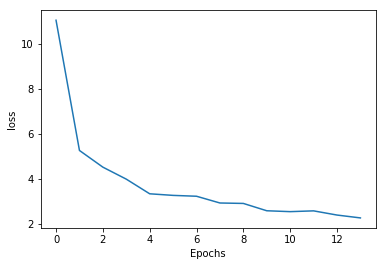

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = []
for l in loss_list:
    loss.append(l[1])

plt.plot(epoch_list, loss)
#plt.title('NLL loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

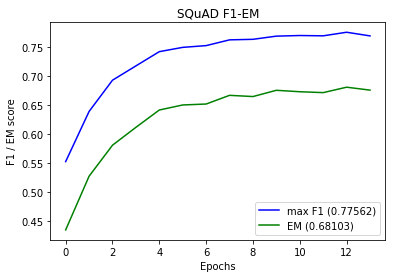

In [34]:
plt.plot(epoch_list, f1_list, 'b', label='max F1 (' + str(str(format(max(f1_list),'.5f'))+')'))
plt.plot(epoch_list, em_list, 'g', label='EM (' + str(str(format(max(em_list),'.5f'))+')'))
plt.title('SQuAD F1-EM')
plt.xlabel('Epochs')
plt.ylabel('F1 / EM score')
plt.legend()
plt.show()

In [20]:
model_name_cur+'_predictions.preds'

'with_topics_best_1525735845_epoch_13_F1_77_56.mdl_predictions.preds'

In [ ]:
# save predictions on development data
reader.load_state_dict(torch.load("data/models/"+model_name_cur+'.pt'))
f1, em, results = validate(dev_loader, reader, dev_offsets, dev_texts, dev_answers, official=True)

with open("data/models/"+model_name_cur+'_predictions.preds','w') as f:
    json.dump(results, f)

In [22]:
f1

0.7756202933940382

In [23]:
em

0.6810254455351187

## On why questions

In [25]:
whys_id = []
whys = []
for sample in dev:
    ques = [ques.lower() for ques in sample['question']]
    if 'why' in ques:
        whys_id.append(sample['id'])
        whys.append(sample)

In [26]:
#'who','when','why',''
why_offsets = {k: dev_offsets[k] for k in dev_offsets.keys() if k in whys_id}
why_texts = {k: dev_texts[k] for k in dev_texts.keys() if k in whys_id}
why_answers = {k: dev_answers[k] for k in dev_answers.keys() if k in whys_id}

#whys[0]

In [27]:
whys_dataset = Transform(whys, word2idx, char2idx,status='test')
whys_sampler = torch.utils.data.sampler.SequentialSampler(whys_dataset)
whys_loader = torch.utils.data.DataLoader(
        whys_dataset, batch_size=32, sampler=whys_sampler, num_workers=5, collate_fn=pad_batch, pin_memory=True,)

In [28]:
reader.load_state_dict(torch.load("data/models/"+model_name_cur+'.pt'))
f1, em, results = validate(whys_loader, reader, why_offsets, why_texts, why_answers, official=True)

In [32]:
f1

0.6401967853037452

In [33]:
em

0.3924050632911392

In [31]:
#lets look at some predictions
results

{'57337ddc4776f41900660bbe': 'to clean them of plants and sediments',
 '573399b54776f41900660e66': 'solid economic growth',
 '5733a32bd058e614000b5f36': 'their disastrous financial situation',
 '5733140a4776f419006606e4': 'it has survived many wars, conflicts and invasions throughout its long history',
 '5733266d4776f41900660715': 'Due to its central location',
 '57332e48d058e614000b5763': 'Stalin was hostile to the idea of an independent Poland',
 '5733638fd058e614000b59e9': 'not restored by the communist authorities',
 '573368e54776f41900660a53': 'to the location of Warsaw within the border region of several big floral regions',
 '56e0c1617aa994140058e6d6': 'to attend school at the Higher Real Gymnasium',
 '56e0c2bc231d4119001ac389': 'this contact with nature made him stronger, both physically and mentally',
 '56dfa7887aa994140058dfaa': 'to hide the fact that he dropped out of school',
 '56dfaa047aa994140058dfbd': 'not having a residence permit',
 '56e0cd33231d4119001ac3bf': 'not hav